Simulasi dibuat sebagai bukti kredibilitas metode fitting garis absorpsi yang dipakai. Fitting dilakukan untuk mendapatkan parameter-parameter garis yaitu di antaranya letak puncak garis (x0), kolom densitas (N), dan parameter Doppler (b). Simulasi dilakukan untuk empat kondisi: (1) Garis 1 komponen spektrum resolusi tinggi, (2) Garis 1 komponen spektrum resolusi rendah, (3) Garis 2 komponen spektrum resolusi tinggi, dan (4) Garis 2 komponen spektrum resolusi rendah. Untuk simulasi ini digunakan nilai oscillator strength dan koefisien Einstein yang sebenarnya untuk garis doublet MgII λλ2796, 2803.

Untuk kondisi (1) dan (2) nilai benar parameter garis adalah 
- $x_0$ = 2796.3543 Å
- N = 2e13 $cm^{-2}$
- b = 30 km/s 

Sedangkan untuk kondisi (3) dan (4) nilai benar parameter garis adalah 
- $x_{0,1}$ = 2796.3543 Å
- $N_1$ = 2e14 $cm^{-2}$ 
- $b_1$ = 50 km/s 
- $x_{0,2}$ = 2798.3543 Å
- $N_2$ = 1e13 $cm^{-2}$
- $b_2$ = 30 km/s

### Package dan konstanta

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling.models import Voigt1D, Const1D
from astropy.constants import c, m_e
from astropy.convolution import convolve, Gaussian1DKernel

from scipy.optimize import curve_fit, root_scalar, minimize_scalar
from scipy import constants as const

In [24]:
# Data atomik NIST dan konstanta
lambda_2796 = 2796.3543
A_2796 = 2.60e+08
f2796 = 0.6123

lambda_2804 = 2803.5315
A_2804 = 2.57e+08
f2804 = 0.3054

c_kms = c.to('km/s').value
e = 4.8032 * 1e-10

m_mg = 24.305 * 1.66e-27

# (1) Garis 1 komponen spektrum resolusi tinggi

<function matplotlib.pyplot.show(close=None, block=None)>

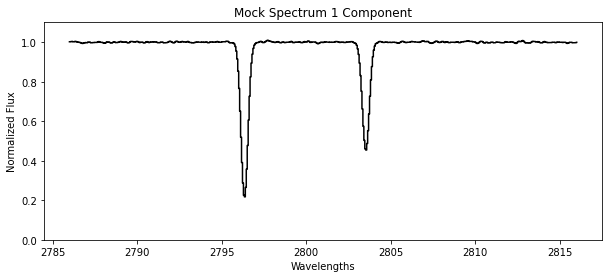

In [32]:
## Pertama akan dibuat data benarnya

# Mock Parameter
N = 2e13
b = 30

# Δλ sesuai resolusi spektrum
R = 50000

num = (2816-2786) / (lambda_2796 / R)
wav = np.linspace(2786, 2816, int(num))

norm_flux = np.ones(int(num))


# Model Voigt
amp_V_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * lambda_2796 * 1e-8 * N) 
                        / (m_e.cgs.value * c.cgs.value * b * 1e5))
amp_V_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * lambda_2804 * 1e-8 * N) 
                        / (m_e.cgs.value * c.cgs.value * b * 1e5))
 
fwhm_L_2796 = ((lambda_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
fwhm_G_2796 = (2 * lambda_2796 * b * np.sqrt(np.log(2))) / c_kms

fwhm_L_2804 = ((lambda_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
fwhm_G_2804 = (2 * lambda_2804 * b * np.sqrt(np.log(2))) / c_kms

voigt_peak_targets = [amp_V_2796, amp_V_2804]
fwhm_Ls = [fwhm_L_2796, fwhm_L_2804]  
fwhm_Gs = [fwhm_G_2796, fwhm_G_2804]          
centers = [lambda_2796, lambda_2804]

def mock_solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
    def mock_residual(amplitude_L):
        model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        return model(0) - target_peak
        
    sol = root_scalar(mock_residual, bracket=[1e-6, 1e6], method='brentq')
    return sol.root
    
models = []
amp_Ls = []

for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
    amp_L = mock_solve_amplitude_L(peak, fwhm_L, fwhm_G)
    amp_Ls.append(amp_L)
    model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
    models.append(model)
    
def mock_combined_voigt(x):
    return sum(m(x) for m in models)
    
true_spectrum = norm_flux + mock_combined_voigt(wav)


# Menambah noise 
np.random.seed(42)
noise = np.random.normal(0, 0.005, size=wav.shape)
true_spectrum += noise


# Konvolusi dengan ISF Gaussian
instrument_sigma = 1.0
kernel = Gaussian1DKernel(stddev=instrument_sigma)
mock_convolved = convolve(true_spectrum, kernel, boundary='extend')

plt.figure(figsize=(10,4))
plt.plot(wav, mock_convolved, 'k', drawstyle='steps-mid')
plt.xlabel("Wavelengths")
plt.ylabel("Normalized Flux")
plt.title('Mock Spectrum 1 Component')
plt.ylim(0, 1.1)
plt.show

In [26]:
## Kemudian dilakukan prosedur fitting modelnya

def convolved_model(wavelengths, x_0_2796, N, b):
    x_0_2804 = x_0_2796 + (lambda_2804 - lambda_2796)

    fwhm_L_2796 = ((x_0_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
    fwhm_L_2804 = ((x_0_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)

    fwhm_G_2796 = (2 * x_0_2796 * b * np.sqrt(np.log(2))) / c_kms
    fwhm_G_2804 = (2 * x_0_2804 * b * np.sqrt(np.log(2))) / c_kms

    amp_V_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * x_0_2796 * 1e-8 * N) / (m_e.cgs.value * c.cgs.value * b * 1e5))
    amp_V_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * x_0_2804 * 1e-8 * N) / (m_e.cgs.value * c.cgs.value * b * 1e5))
    
    voigt_peak_targets = [amp_V_2796, amp_V_2804]
    fwhm_Ls = [fwhm_L_2796, fwhm_L_2804]  
    fwhm_Gs = [fwhm_G_2796, fwhm_G_2804]          
    centers = [x_0_2796, x_0_2804]

    def solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
        def residual(amplitude_L):
            model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
            return model(0) - target_peak

        sol = root_scalar(residual, bracket=[1e-6, 1e6], method='brentq')
        return sol.root

    models = []

    for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
        amp_L = solve_amplitude_L(peak, fwhm_L, fwhm_G)
        model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        models.append(model)
    models.append(Const1D(amplitude=1.0))

    def combined_voigt(x):
        return sum(m(x) for m in models)

    intrinsic_profile = combined_voigt(wavelengths)
    return convolve(intrinsic_profile, kernel, normalize_kernel=True, boundary='fill', fill_value=1.0)

# Tebakan awal [x0, N, b]
p0 = [2796, 1e13, 25]

# Batasan hasil parameter fitting ([batas bawah], [batas atas])
bounds = ([2795,1e12,1], 
          [2797,1e14,100])

popt, _ = curve_fit(convolved_model, wav, mock_convolved, p0=p0, bounds=bounds, 
                    sigma=noise, absolute_sigma=True, maxfev=5000)

print(f'Fitted x0 :{popt[0]:.3f}')
print(f'Fitted N :{popt[1]:.3e}')
print(f'Fitted b :{popt[2]:.3f}')

Fitted x0 :2796.356
Fitted N :1.968e+13
Fitted b :29.796


In [27]:
## Dihitung Reduced Chi-squared sebagai penilaian kualitas fitting.

residuals = mock_convolved - convolved_model(wav, *popt)

def set_floor(sigma_floor):
    sigma_adjusted = np.sqrt(noise**2 + sigma_floor**2)
    std = np.std(residuals / sigma_adjusted)
    return abs(std - 1)  # Goal: std close to 1

floor = minimize_scalar(set_floor, bounds=(0, 0.01))

optimal_sigma_floor = floor.x
sigma_adjusted = np.sqrt(noise**2 + optimal_sigma_floor**2)
std = np.std(residuals / sigma_adjusted)

chi_squared = np.sum((residuals / sigma_adjusted) ** 2)
dof = len(mock_convolved) - len(popt)

reduced_chi_squared = chi_squared / dof

print(f'Floor noise: {optimal_sigma_floor:.5f}')
print(f'Chi-squared: {chi_squared:.3f}')
print(f'Degree of freedom: {dof:.3f}')
print(f'Reduced Chi-squared: {reduced_chi_squared:.3f}')

Floor noise: 0.00094
Chi-squared: 547.799
Degree of freedom: 533.000
Reduced Chi-squared: 1.028


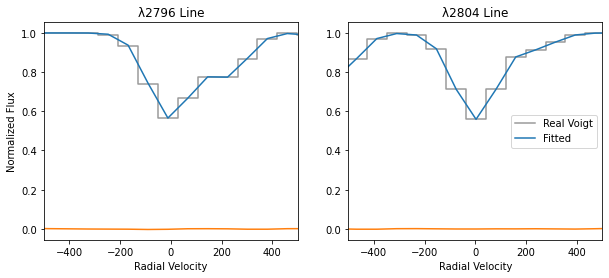

In [60]:
## Visualisasi

v_2796 = c_kms * (wav - lambda_2796) / lambda_2796
v_2804 = c_kms * (wav - lambda_2804) / lambda_2804

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

ax[0].plot(v_2796, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8)
ax[0].plot(v_2796, convolved_model(wav, *popt))
ax[0].plot(v_2796, residuals)
ax[0].set_xlim(-500, 500)
ax[0].set_xlabel('Radial Velocity')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_title('λ2796 Line')

ax[1].plot(v_2804, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8, label='Real Voigt')
ax[1].plot(v_2804, convolved_model(wav, *popt), label='Fitted')
ax[1].plot(v_2804, residuals)
ax[1].set_xlim(-500, 500)
ax[1].set_xlabel('Radial Velocity')
ax[1].set_title('λ2804 Line')
ax[1].legend()

# (2) Garis 1 komponen spektrum resolusi rendah

<function matplotlib.pyplot.show(close=None, block=None)>

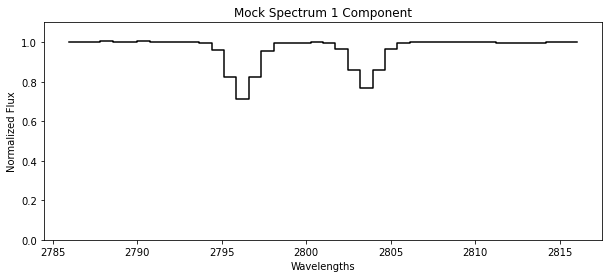

In [33]:
## Pertama akan dibuat data benarnya

# Mock Parameter, sama seperti sebelumnya
N = 2e13
b = 30

# Δλ sesuai resolusi spektrum
R = 4000

num = (2816-2786) / (lambda_2796 / R)
wav = np.linspace(2786, 2816, int(num))

norm_flux = np.ones(int(num))


# Model Voigt
amp_V_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * lambda_2796 * 1e-8 * N) 
                        / (m_e.cgs.value * c.cgs.value * b * 1e5))
amp_V_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * lambda_2804 * 1e-8 * N) 
                        / (m_e.cgs.value * c.cgs.value * b * 1e5))
 
fwhm_L_2796 = ((lambda_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
fwhm_G_2796 = (2 * lambda_2796 * b * np.sqrt(np.log(2))) / c_kms

fwhm_L_2804 = ((lambda_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
fwhm_G_2804 = (2 * lambda_2804 * b * np.sqrt(np.log(2))) / c_kms

voigt_peak_targets = [amp_V_2796, amp_V_2804]
fwhm_Ls = [fwhm_L_2796, fwhm_L_2804]  
fwhm_Gs = [fwhm_G_2796, fwhm_G_2804]          
centers = [lambda_2796, lambda_2804]

def mock_solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
    def mock_residual(amplitude_L):
        model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        return model(0) - target_peak
        
    sol = root_scalar(mock_residual, bracket=[1e-6, 1e6], method='brentq')
    return sol.root
    
models = []
amp_Ls = []

for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
    amp_L = mock_solve_amplitude_L(peak, fwhm_L, fwhm_G)
    amp_Ls.append(amp_L)
    model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
    models.append(model)
    
def mock_combined_voigt(x):
    return sum(m(x) for m in models)
    
true_spectrum = norm_flux + mock_combined_voigt(wav)


# Menambah noise 
np.random.seed(42)
noise = np.random.normal(0, 0.005, size=wav.shape)
true_spectrum += noise


# Konvolusi dengan ISF
instrument_sigma = 1.0
kernel = Gaussian1DKernel(stddev=instrument_sigma)
mock_convolved = convolve(true_spectrum, kernel, boundary='extend')

plt.figure(figsize=(10,4))
plt.plot(wav, mock_convolved, 'k', drawstyle='steps-mid')
plt.xlabel("Wavelengths")
plt.ylabel("Normalized Flux")
plt.title('Mock Spectrum 1 Component')
plt.ylim(0, 1.1)
plt.show

In [34]:
## Kemudian dilakukan prosedur fitting modelnya

def convolved_model(wavelengths, x_0_2796, N, b):
    x_0_2804 = x_0_2796 + (lambda_2804 - lambda_2796)

    fwhm_L_2796 = ((x_0_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
    fwhm_L_2804 = ((x_0_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)

    fwhm_G_2796 = (2 * x_0_2796 * b * np.sqrt(np.log(2))) / c_kms
    fwhm_G_2804 = (2 * x_0_2804 * b * np.sqrt(np.log(2))) / c_kms

    amp_V_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * x_0_2796 * 1e-8 * N) / (m_e.cgs.value * c.cgs.value * b * 1e5))
    amp_V_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * x_0_2804 * 1e-8 * N) / (m_e.cgs.value * c.cgs.value * b * 1e5))
    
    voigt_peak_targets = [amp_V_2796, amp_V_2804]
    fwhm_Ls = [fwhm_L_2796, fwhm_L_2804]  
    fwhm_Gs = [fwhm_G_2796, fwhm_G_2804]          
    centers = [x_0_2796, x_0_2804]

    def solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
        def residual(amplitude_L):
            model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
            return model(0) - target_peak

        sol = root_scalar(residual, bracket=[1e-6, 1e6], method='brentq')
        return sol.root

    models = []

    for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
        amp_L = solve_amplitude_L(peak, fwhm_L, fwhm_G)
        model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        models.append(model)
    models.append(Const1D(amplitude=1.0))

    def combined_voigt(x):
        return sum(m(x) for m in models)

    intrinsic_profile = combined_voigt(wavelengths)
    return convolve(intrinsic_profile, kernel, normalize_kernel=True, boundary='fill', fill_value=1.0)


# Tebakan awal [x0, N, b]
p0 = [2796, 1e13, 25]

# Batasan hasil parameter fitting ([batas bawah], [batas atas])
bounds = ([2795,1e12,1], 
          [2797,1e14,100])

popt, _ = curve_fit(convolved_model, wav, mock_convolved, p0=p0, bounds=bounds, 
                    sigma=noise, absolute_sigma=True, maxfev=5000)

print(f'Fitted x0 :{popt[0]:.3f}')
print(f'Fitted N :{popt[1]:.3e}')
print(f'Fitted b :{popt[2]:.3f}')

Fitted x0 :2796.362
Fitted N :2.288e+13
Fitted b :34.074


In [35]:
## Dihitung Reduced Chi-squared sebagai penilaian kualitas fitting.

residuals = mock_convolved - convolved_model(wav, *popt)

def set_floor(sigma_floor):
    sigma_adjusted = np.sqrt(noise**2 + sigma_floor**2)
    std = np.std(residuals / sigma_adjusted)
    return abs(std - 1)  # Goal: std close to 1

floor = minimize_scalar(set_floor, bounds=(0, 0.01))

optimal_sigma_floor = floor.x
sigma_adjusted = np.sqrt(noise**2 + optimal_sigma_floor**2)
std = np.std(residuals / sigma_adjusted)

chi_squared = np.sum((residuals / sigma_adjusted) ** 2)
dof = len(mock_convolved) - len(popt)

reduced_chi_squared = chi_squared / dof

print(f'Floor noise: {optimal_sigma_floor:.5f}')
print(f'Chi-squared: {chi_squared:.3f}')
print(f'Degree of freedom: {dof:.3f}')
print(f'Reduced Chi-squared: {reduced_chi_squared:.3f}')

Floor noise: 0.00039
Chi-squared: 42.177
Degree of freedom: 39.000
Reduced Chi-squared: 1.081


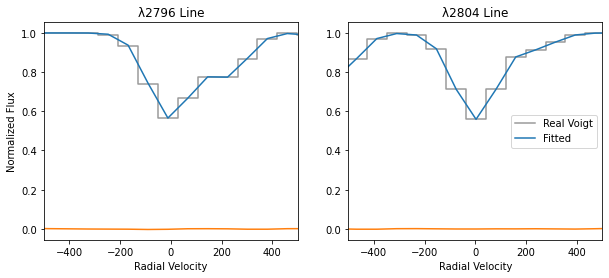

In [56]:
## Visualisasi

v_2796 = c_kms * (wav - lambda_2796) / lambda_2796
v_2804 = c_kms * (wav - lambda_2804) / lambda_2804

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

ax[0].plot(v_2796, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8)
ax[0].plot(v_2796, convolved_model(wav, *popt))
ax[0].plot(v_2796, residuals)
ax[0].set_xlim(-500, 500)
ax[0].set_xlabel('Radial Velocity')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_title('λ2796 Line')

ax[1].plot(v_2804, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8, label='Real Voigt')
ax[1].plot(v_2804, convolved_model(wav, *popt), label='Fitted')
ax[1].plot(v_2804, residuals)
ax[1].set_xlim(-500, 500)
ax[1].set_xlabel('Radial Velocity')
ax[1].set_title('λ2804 Line')
ax[1].legend()

# (3) Garis 2 komponen spektrum resolusi tinggi

<function matplotlib.pyplot.show(close=None, block=None)>

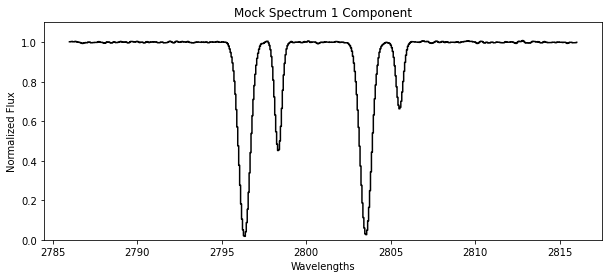

In [39]:
## Pertama dibuat data benarnya

# Mock Parameter
N1 = 2e14
N2 = 1e13
b1 = 50
b2 = 30

# Δλ sesuai resolusi spektrum
R = 50000

num = (2816-2786) / (lambda_2796 / R)
wav = np.linspace(2786, 2816, int(num))

norm_flux = np.ones(int(num))


# Model Voigt
x02_2796 = lambda_2796 + 2
x02_2804 = lambda_2804 + 2

amp_V1_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * lambda_2796 * 1e-8 * N1) 
                        / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
amp_V2_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * lambda_2796 * 1e-8 * N2) 
                        / (m_e.cgs.value * c.cgs.value * b2 * 1e5))
amp_V1_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * lambda_2804 * 1e-8 * N1) 
                        / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
amp_V2_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * lambda_2804 * 1e-8 * N2) 
                        / (m_e.cgs.value * c.cgs.value * b2 * 1e5))

fwhm_L1_2796 = ((lambda_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
fwhm_L2_2796 = ((lambda_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
fwhm_G1_2796 = (2 * lambda_2796 * b1 * np.sqrt(np.log(2))) / c_kms
fwhm_G2_2796 = (2 * lambda_2796 * b2 * np.sqrt(np.log(2))) / c_kms

fwhm_L1_2804 = ((lambda_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
fwhm_L2_2804 = ((lambda_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
fwhm_G1_2804 = (2 * lambda_2804 * b1 * np.sqrt(np.log(2))) / c_kms
fwhm_G2_2804 = (2 * lambda_2804 * b2 * np.sqrt(np.log(2))) / c_kms

voigt_peak_targets = [amp_V1_2796, amp_V2_2796, amp_V1_2804, amp_V2_2804]
fwhm_Ls = [fwhm_L1_2796, fwhm_L2_2796, fwhm_L1_2804, fwhm_L2_2804]  
fwhm_Gs = [fwhm_G1_2796, fwhm_G2_2796, fwhm_G1_2804, fwhm_G2_2804]          
centers = [lambda_2796, x02_2796, lambda_2804, x02_2804]

def mock_solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
    def mock_residual(amplitude_L):
        model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        return model(0) - target_peak
        
    sol = root_scalar(mock_residual, bracket=[1e-6, 1e6], method='brentq')
    return sol.root
    
models = []
amp_Ls = []

for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
    amp_L = mock_solve_amplitude_L(peak, fwhm_L, fwhm_G)
    amp_Ls.append(amp_L)
    model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
    models.append(model)
    
def mock_combined_voigt(x):
    return sum(m(x) for m in models)
    
true_spectrum = norm_flux + mock_combined_voigt(wav)


# Menambah noise 
np.random.seed(42)
noise = np.random.normal(0, 0.005, size=wav.shape)
true_spectrum += noise


# Konvolusi dengan ISF
instrument_sigma = 1.0
kernel = Gaussian1DKernel(stddev=instrument_sigma)
mock_convolved = convolve(true_spectrum, kernel, boundary='extend')

plt.figure(figsize=(10,4))
plt.plot(wav, mock_convolved, 'k', drawstyle='steps-mid')
plt.xlabel("Wavelengths")
plt.ylabel("Normalized Flux")
plt.title('Mock Spectrum 1 Component')
plt.ylim(0, 1.1)
plt.show

In [40]:
## Kemudian dilakukan prosedur fitting

def convolved_model(wavelengths, x_01_2796, N1, b1, x_02_2796, N2, b2):
    x_01_2804 = x_01_2796 + (lambda_2804 - lambda_2796)
    x_02_2804 = x_02_2796 + (lambda_2804 - lambda_2796)

    fwhm_L1_2796 = ((x_01_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
    fwhm_L2_2796 = ((x_02_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
    fwhm_L1_2804 = ((x_01_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
    fwhm_L2_2804 = ((x_02_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)

    fwhm_G1_2796 = (2 * x_01_2796 * b1 * np.sqrt(np.log(2))) / c_kms
    fwhm_G2_2796 = (2 * x_02_2796 * b2 * np.sqrt(np.log(2))) / c_kms
    fwhm_G1_2804 = (2 * x_01_2804 * b1 * np.sqrt(np.log(2))) / c_kms
    fwhm_G2_2804 = (2 * x_02_2804 * b2 * np.sqrt(np.log(2))) / c_kms

    amp_V1_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * x_01_2796 * 1e-8 * N1) / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
    amp_V2_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * x_02_2796 * 1e-8 * N2) / (m_e.cgs.value * c.cgs.value * b2 * 1e5))
    amp_V1_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * x_01_2804 * 1e-8 * N1) / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
    amp_V2_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * x_02_2804 * 1e-8 * N2) / (m_e.cgs.value * c.cgs.value * b2 * 1e5))
    
    voigt_peak_targets = [amp_V1_2796, amp_V2_2796, amp_V1_2804, amp_V2_2804]
    fwhm_Ls = [fwhm_L1_2796, fwhm_L2_2796, fwhm_L1_2804, fwhm_L2_2804]  
    fwhm_Gs = [fwhm_G1_2796, fwhm_G2_2796, fwhm_G1_2804, fwhm_G2_2804]          
    centers = [x_01_2796, x_02_2796, x_01_2804, x_02_2804]

    def solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
        def residual(amplitude_L):
            model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
            return model(0) - target_peak

        sol = root_scalar(residual, bracket=[1e-6, 1e6], method='brentq')
        return sol.root

    models = []

    for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
        amp_L = solve_amplitude_L(peak, fwhm_L, fwhm_G)
        model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        models.append(model)
    models.append(Const1D(amplitude=1.0))

    def combined_voigt(x):
        return sum(m(x) for m in models)

    intrinsic_profile = combined_voigt(wavelengths)
    return convolve(intrinsic_profile, kernel, normalize_kernel=True, boundary='fill', fill_value=1.0)


# Tebakan awal [x0_1, N_1, b_1, x0_2, N_2, b_2]
p0 = ([lambda_2796, 1e14, 60,
      x02_2796, 2e13, 20])

# Batasan hasil parameter fitting ([batas bawah], [batas atas])
bounds = ([2795,1e12,1,
          2797,1e12,1], 
          [2797,1e15,100,
          2800,1e15,100])


popt, _ = curve_fit(convolved_model, wav, mock_convolved, p0=p0, bounds=bounds, 
                    sigma=noise, absolute_sigma=True, maxfev=5000)

print(f'Fitted x01 :{popt[0]:.3f}')
print(f'Fitted N1:{popt[1]:.3e}')
print(f'Fitted b1 :{popt[2]:.3f}')
print(f'Fitted x02 :{popt[3]:.3f}')
print(f'Fitted N2 :{popt[4]:.3e}')
print(f'Fitted b2 :{popt[5]:.3f}')

Fitted x01 :2796.355
Fitted N1:1.861e+14
Fitted b1 :49.916
Fitted x02 :2798.354
Fitted N2 :9.993e+12
Fitted b2 :30.261


In [41]:
## Dihitung Reduced Chi-squarednya

residuals = mock_convolved - convolved_model(wav, *popt)

def set_floor(sigma_floor):
    sigma_adjusted = np.sqrt(noise**2 + sigma_floor**2)
    std = np.std(residuals / sigma_adjusted)
    return abs(std - 1)  # Goal: std close to 1

floor = minimize_scalar(set_floor, bounds=(0, 0.01))

optimal_sigma_floor = floor.x
sigma_adjusted = np.sqrt(noise**2 + optimal_sigma_floor**2)
std = np.std(residuals / sigma_adjusted)

chi_squared = np.sum((residuals / sigma_adjusted) ** 2)
dof = len(mock_convolved) - len(popt)

reduced_chi_squared = chi_squared / dof

print(f'Floor noise: {optimal_sigma_floor:.5f}')
print(f'Chi-squared: {chi_squared:.3f}')
print(f'Degree of freedom: {dof:.3f}')
print(f'Reduced Chi-squared: {reduced_chi_squared:.3f}')

Floor noise: 0.00089
Chi-squared: 540.951
Degree of freedom: 530.000
Reduced Chi-squared: 1.021


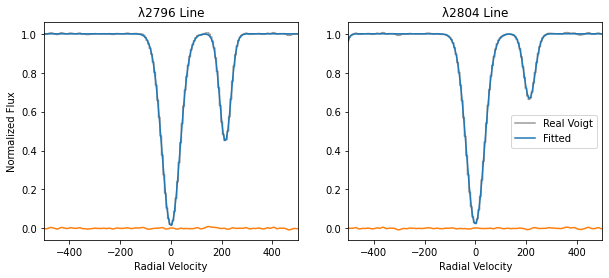

In [44]:
## Visualisasi

v_2796 = c_kms * (wav - lambda_2796) / lambda_2796
v_2804 = c_kms * (wav - lambda_2804) / lambda_2804

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

ax[0].plot(v_2796, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8)
ax[0].plot(v_2796, convolved_model(wav, *popt))
ax[0].plot(v_2796, residuals)
ax[0].set_xlim(-500, 500)
ax[0].set_xlabel('Radial Velocity')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_title('λ2796 Line')

ax[1].plot(v_2804, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8, label='Real Voigt')
ax[1].plot(v_2804, convolved_model(wav, *popt), label='Fitted')
ax[1].plot(v_2804, residuals)
ax[1].set_xlim(-500, 500)
ax[1].set_xlabel('Radial Velocity')
ax[1].set_title('λ2804 Line')
ax[1].legend()

# (4) Garis 2 komponen spektrum resolusi rendah

<function matplotlib.pyplot.show(close=None, block=None)>

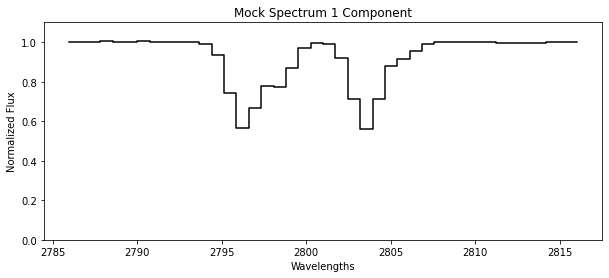

In [49]:
## Pertama dibuat data benarnya
##

# Mock Parameter, sama seperti sebelumnya
N1 = 2e14
N2 = 1e13
b1 = 50
b2 = 30

# Δλ sesuai resolusi spektrum
R = 4000

num = (2816-2786) / (lambda_2796 / R)
wav = np.linspace(2786, 2816, int(num))

norm_flux = np.ones(int(num))


# Model Voigt
x02_2796 = lambda_2796 + 2
x02_2804 = lambda_2804 + 2

amp_V1_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * lambda_2796 * 1e-8 * N1) 
                        / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
amp_V2_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * lambda_2796 * 1e-8 * N2) 
                        / (m_e.cgs.value * c.cgs.value * b2 * 1e5))
amp_V1_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * lambda_2804 * 1e-8 * N1) 
                        / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
amp_V2_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * lambda_2804 * 1e-8 * N2) 
                        / (m_e.cgs.value * c.cgs.value * b2 * 1e5))

fwhm_L1_2796 = ((lambda_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
fwhm_L2_2796 = ((lambda_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
fwhm_G1_2796 = (2 * lambda_2796 * b1 * np.sqrt(np.log(2))) / c_kms
fwhm_G2_2796 = (2 * lambda_2796 * b2 * np.sqrt(np.log(2))) / c_kms

fwhm_L1_2804 = ((lambda_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
fwhm_L2_2804 = ((lambda_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
fwhm_G1_2804 = (2 * lambda_2804 * b1 * np.sqrt(np.log(2))) / c_kms
fwhm_G2_2804 = (2 * lambda_2804 * b2 * np.sqrt(np.log(2))) / c_kms

voigt_peak_targets = [amp_V1_2796, amp_V2_2796, amp_V1_2804, amp_V2_2804]
fwhm_Ls = [fwhm_L1_2796, fwhm_L2_2796, fwhm_L1_2804, fwhm_L2_2804]  
fwhm_Gs = [fwhm_G1_2796, fwhm_G2_2796, fwhm_G1_2804, fwhm_G2_2804]          
centers = [lambda_2796, x02_2796, lambda_2804, x02_2804]

def mock_solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
    def mock_residual(amplitude_L):
        model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        return model(0) - target_peak
        
    sol = root_scalar(mock_residual, bracket=[1e-6, 1e6], method='brentq')
    return sol.root
    
models = []
amp_Ls = []

for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
    amp_L = mock_solve_amplitude_L(peak, fwhm_L, fwhm_G)
    amp_Ls.append(amp_L)
    model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
    models.append(model)
    
def mock_combined_voigt(x):
    return sum(m(x) for m in models)
    
true_spectrum = norm_flux + mock_combined_voigt(wav)


# Menambah noise 
np.random.seed(42)
noise = np.random.normal(0, 0.005, size=wav.shape)
true_spectrum += noise


# Konvolusi dengan ISF
instrument_sigma = 1.0
kernel = Gaussian1DKernel(stddev=instrument_sigma)
mock_convolved = convolve(true_spectrum, kernel, boundary='extend')

plt.figure(figsize=(10,4))
plt.plot(wav, mock_convolved, 'k', drawstyle='steps-mid')
plt.xlabel("Wavelengths")
plt.ylabel("Normalized Flux")
plt.title('Mock Spectrum 1 Component')
plt.ylim(0, 1.1)
plt.show

In [50]:
## Kemudian dilakukan prosedur fitting

def convolved_model(wavelengths, x_01_2796, N1, b1, x_02_2796, N2, b2):
    x_01_2804 = x_01_2796 + (lambda_2804 - lambda_2796)
    x_02_2804 = x_02_2796 + (lambda_2804 - lambda_2796)

    fwhm_L1_2796 = ((x_01_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
    fwhm_L2_2796 = ((x_02_2796**2) * A_2796) / (2 * np.pi * c.value * 1e10)
    fwhm_L1_2804 = ((x_01_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)
    fwhm_L2_2804 = ((x_02_2804**2) * A_2804) / (2 * np.pi * c.value * 1e10)

    fwhm_G1_2796 = (2 * x_01_2796 * b1 * np.sqrt(np.log(2))) / c_kms
    fwhm_G2_2796 = (2 * x_02_2796 * b2 * np.sqrt(np.log(2))) / c_kms
    fwhm_G1_2804 = (2 * x_01_2804 * b1 * np.sqrt(np.log(2))) / c_kms
    fwhm_G2_2804 = (2 * x_02_2804 * b2 * np.sqrt(np.log(2))) / c_kms

    amp_V1_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * x_01_2796 * 1e-8 * N1) / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
    amp_V2_2796 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2796 * x_02_2796 * 1e-8 * N2) / (m_e.cgs.value * c.cgs.value * b2 * 1e5))
    amp_V1_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * x_01_2804 * 1e-8 * N1) / (m_e.cgs.value * c.cgs.value * b1 * 1e5))
    amp_V2_2804 = 1 - np.exp(-(np.sqrt(np.pi) * e**2 * f2804 * x_02_2804 * 1e-8 * N2) / (m_e.cgs.value * c.cgs.value * b2 * 1e5))
    
    voigt_peak_targets = [amp_V1_2796, amp_V2_2796, amp_V1_2804, amp_V2_2804]
    fwhm_Ls = [fwhm_L1_2796, fwhm_L2_2796, fwhm_L1_2804, fwhm_L2_2804]  
    fwhm_Gs = [fwhm_G1_2796, fwhm_G2_2796, fwhm_G1_2804, fwhm_G2_2804]          
    centers = [x_01_2796, x_02_2796, x_01_2804, x_02_2804]

    def solve_amplitude_L(target_peak, fwhm_L, fwhm_G):
        def residual(amplitude_L):
            model = Voigt1D(amplitude_L=amplitude_L, x_0=0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
            return model(0) - target_peak

        sol = root_scalar(residual, bracket=[1e-6, 1e6], method='brentq')
        return sol.root

    models = []

    for peak, fwhm_L, fwhm_G, x0 in zip(voigt_peak_targets, fwhm_Ls, fwhm_Gs, centers):
        amp_L = solve_amplitude_L(peak, fwhm_L, fwhm_G)
        model = Voigt1D(amplitude_L=-amp_L, x_0=x0, fwhm_L=fwhm_L, fwhm_G=fwhm_G)
        models.append(model)
    models.append(Const1D(amplitude=1.0))

    def combined_voigt(x):
        return sum(m(x) for m in models)

    intrinsic_profile = combined_voigt(wavelengths)
    return convolve(intrinsic_profile, kernel, normalize_kernel=True, boundary='fill', fill_value=1.0)

# Tebakan awal [x0_1, N_1, b_1, x0_2, N_2, b_2]
p0 = ([lambda_2796, 1e14, 60,
      x02_2796, 2e13, 20])

# Batasan hasil parameter fitting ([batas bawah], [batas atas])
bounds = ([2795,1e12,1,
          2797,1e12,1], 
          [2797,1e15,100,
          2800,1e15,100])

# Fitting least-squares
popt, _ = curve_fit(convolved_model, wav, mock_convolved, p0=p0, bounds=bounds, 
                    sigma=noise, absolute_sigma=True, maxfev=5000)

print(f'Fitted x01 :{popt[0]:.3f}')
print(f'Fitted N1:{popt[1]:.3e}')
print(f'Fitted b1 :{popt[2]:.3f}')
print(f'Fitted x02 :{popt[3]:.3f}')
print(f'Fitted N2 :{popt[4]:.3e}')
print(f'Fitted b2 :{popt[5]:.3f}')

Fitted x01 :2796.355
Fitted N1:1.844e+14
Fitted b1 :50.914
Fitted x02 :2798.364
Fitted N2 :9.745e+12
Fitted b2 :29.658


In [51]:
residuals = mock_convolved - convolved_model(wav, *popt)

def set_floor(sigma_floor):
    sigma_adjusted = np.sqrt(noise**2 + sigma_floor**2)
    std = np.std(residuals / sigma_adjusted)
    return abs(std - 1)  # Goal: std close to 1

floor = minimize_scalar(set_floor, bounds=(0, 0.01))

optimal_sigma_floor = floor.x
sigma_adjusted = np.sqrt(noise**2 + optimal_sigma_floor**2)
std = np.std(residuals / sigma_adjusted)

chi_squared = np.sum((residuals / sigma_adjusted) ** 2)
dof = len(mock_convolved) - len(popt)

reduced_chi_squared = chi_squared / dof

print(f'Floor noise: {optimal_sigma_floor:.5f}')
print(f'Chi-squared: {chi_squared:.3f}')
print(f'Degree of freedom: {dof:.3f}')
print(f'Reduced Chi-squared: {reduced_chi_squared:.3f}')

Floor noise: 0.00029
Chi-squared: 42.647
Degree of freedom: 36.000
Reduced Chi-squared: 1.185


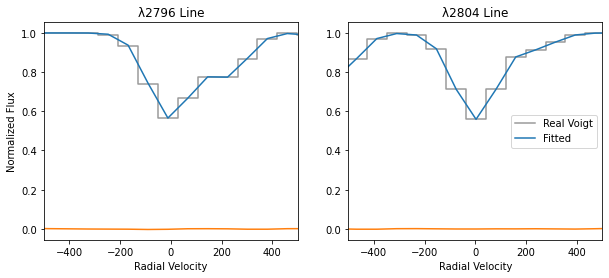

In [54]:
## Visualisasi

v_2796 = c_kms * (wav - lambda_2796) / lambda_2796
v_2804 = c_kms * (wav - lambda_2804) / lambda_2804

fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

ax[0].plot(v_2796, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8)
ax[0].plot(v_2796, convolved_model(wav, *popt))
ax[0].plot(v_2796, residuals)
ax[0].set_xlim(-500, 500)
ax[0].set_xlabel('Radial Velocity')
ax[0].set_ylabel('Normalized Flux')
ax[0].set_title('λ2796 Line')

ax[1].plot(v_2804, mock_convolved, color='grey', drawstyle='steps-mid', alpha=0.8, label='Real Voigt')
ax[1].plot(v_2804, convolved_model(wav, *popt), label='Fitted')
ax[1].plot(v_2804, residuals)
ax[1].set_xlim(-500, 500)
ax[1].set_xlabel('Radial Velocity')
ax[1].set_title('λ2804 Line')
ax[1].legend()